In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
num_boxes = 50
num_classes = 5
image_size = 500

# generate random bounding boxes
boxes = []
for _ in range(num_boxes):
    x_min = np.random.randint(0, image_size // 2)
    y_min = np.random.randint(0, image_size // 2)
    x_max = np.random.randint(image_size // 2, image_size)
    y_max = np.random.randint(image_size // 2, image_size)
    
    boxes.append([x_min, y_min, x_max, y_max])

boxes = np.array(boxes)

# generate random confidence scores
scores = np.random.rand(num_boxes)

# generate random class labels (from 0 to num_classes-1)
classes = np.random.randint(0, num_classes, size=num_boxes)

print("Bounding Boxes:\n", boxes)
print("\nConfidence Scores:\n", scores)
print("\nClass Labels:\n", classes)

Bounding Boxes:
 [[193  75 298 386]
 [ 92  97 384 385]
 [102 184 391 391]
 [ 87  56 317 416]
 [160 141 463 331]
 [ 28   6 384 291]
 [196   5 362 485]
 [ 41 124 363 434]
 [ 41 117 456 337]
 [167  67 491 377]
 [ 16 234 405 476]
 [198 104 261 375]
 [210  34 327 494]
 [240  36 265 355]
 [146   4 379 488]
 [139  69 354 326]
 [221  13 389 421]
 [106 133 297 310]
 [202 176 399 379]
 [  7 129 364 309]
 [225 227 305 359]
 [ 81 102 309 463]
 [ 96  49 254 444]
 [131  78 358 355]
 [160 157 266 481]
 [ 21  71 288 298]
 [216 129 332 392]
 [200 179 486 379]
 [ 53 243 470 356]
 [ 35 127 464 383]
 [101   6 269 446]
 [ 49 242 334 436]
 [100   5 447 406]
 [210  70 427 442]
 [170  65 294 443]
 [210   1 258 313]
 [208 197 410 343]
 [170  32 289 362]
 [  5 107 476 286]
 [244 206 283 274]
 [203 144 415 388]
 [181 142 455 413]
 [138 227 481 442]
 [149  62 484 258]
 [ 91 118 356 498]
 [213 196 374 498]
 [140 205 447 348]
 [162  92 273 380]
 [129 111 496 356]
 [  8  96 285 399]]

Confidence Scores:
 [0.09142911

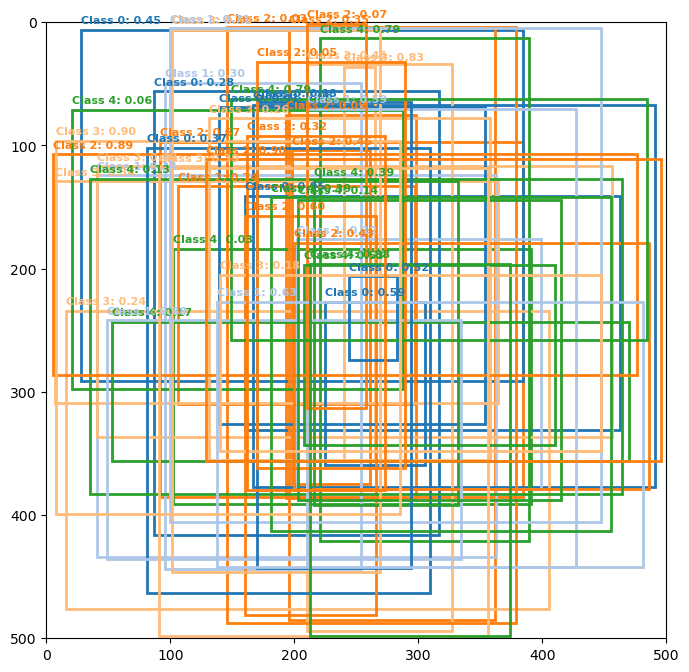

In [3]:
def visualize_boxes(boxes, scores, classes, image_size=500):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.set_xlim([0, image_size])
    ax.set_ylim([0, image_size])
    ax.invert_yaxis()

    colors = plt.cm.tab20.colors

    for i in range(len(boxes)):
        box = boxes[i]
        class_id = classes[i]
        score = scores[i]
        
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        
        rect = patches.Rectangle((x_min, y_min), width, height, 
                                 linewidth=2, edgecolor=colors[class_id], facecolor='none')
        ax.add_patch(rect)
        
        label = f"Class {class_id}: {score:.2f}"
        plt.text(x_min, y_min - 5, label, color=colors[class_id], fontsize=8, weight='bold')

    plt.show()

visualize_boxes(boxes, scores, classes)

In [4]:
# IoU function
def iou(box1, box2):
    #coordinates of the intersection box
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    # area of both bounding boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    # union area
    union_area = box1_area + box2_area - intersection_area
    
    # IoU
    iou_value = intersection_area / union_area
    return iou_value

In [5]:
# NMS algo
def non_max_suppression(boxes, scores, iou_threshold, score_threshold=0.8):
    boxes = np.array(boxes)
    scores = np.array(scores)
    
    valid_indices = np.where(scores > score_threshold)[0]
    boxes = boxes[valid_indices]
    scores = scores[valid_indices]
    
    if len(boxes) == 0:
        return []
    
    selected_indices = []
    
    indices = np.argsort(scores)[::-1]
    
    while len(indices) > 0:
        current = indices[0]
        selected_indices.append(valid_indices[current])
        
        remaining_indices = indices[1:]
        to_keep = []
        
        for idx in remaining_indices:
            iou_value = iou(boxes[current], boxes[idx])
            
            if iou_value < iou_threshold:
                to_keep.append(idx)
        
        indices = np.array(to_keep)

    return selected_indices

In [6]:
# NMS + classes
def non_max_suppression_with_classes(boxes, scores, classes, iou_threshold, score_threshold):
    
    selected_indices = []
    unique_classes = np.unique(classes)
    
    for class_id in unique_classes:
        class_indices = np.where(classes == class_id)[0]
        class_boxes = boxes[class_indices]
        class_scores = scores[class_indices]
        
        # boxes with score above score_threshold
        valid_indices = np.where(class_scores > score_threshold)[0]
        class_boxes = class_boxes[valid_indices]
        class_scores = class_scores[valid_indices]
        class_valid_indices = class_indices[valid_indices]

        if len(class_boxes) == 0:
            continue
        
        sorted_indices = np.argsort(class_scores)[::-1]

        # apply NMS
        while len(sorted_indices) > 0:
            #box with the highest score
            current = sorted_indices[0]
            selected_indices.append(class_valid_indices[current])
            
            #compare the current box with the rest of the boxes
            remaining_indices = sorted_indices[1:]
            to_keep = []
            
            for idx in remaining_indices:
                # compute IoU between the current box and the remaining boxes
                iou_value = iou(class_boxes[current], class_boxes[idx])
                
                # if IoU is below the threshold, keep the box
                if iou_value < iou_threshold:
                    to_keep.append(idx)
            
            # update the list of boxes to be checked
            sorted_indices = np.array(to_keep)
    
    return selected_indices

Selected bounding boxes:
Box 5: [160 141 463 331], Score: 0.9462576972598438, Class: 0
Box 16: [139  69 354 326], Score: 0.9093284934185968, Class: 0
Box 32: [ 49 242 334 436], Score: 0.8838916210019649, Class: 1
Box 49: [129 111 496 356], Score: 0.9037425690651759, Class: 2
Box 50: [  8  96 285 399], Score: 0.896017334940678, Class: 3
Box 14: [240  36 265 355], Score: 0.8304854464174216, Class: 3
Box 46: [213 196 374 498], Score: 0.8827250050881004, Class: 4


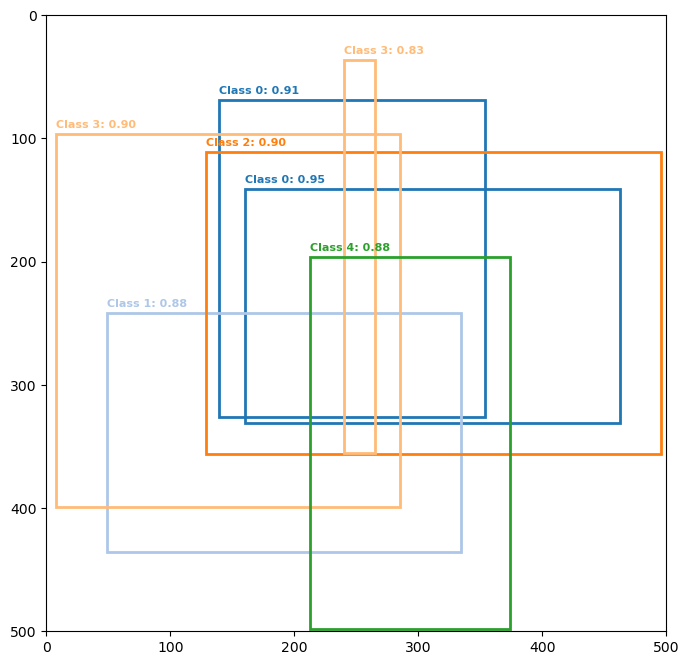

In [7]:
iou_threshold = 0.5
score_threshold = 0.8

selected_indices = non_max_suppression_with_classes(boxes, scores, classes, iou_threshold, score_threshold)

print("Selected bounding boxes:")
for i in selected_indices:
    print(f"Box {i+1}: {boxes[i]}, Score: {scores[i]}, Class: {classes[i]}")

visualize_boxes(boxes[selected_indices], scores[selected_indices], classes[selected_indices])